In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from PIL import Image

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

ROOT = Path('../..').resolve()
results_dir = ROOT/'results/xSAGA-init'

In [2]:
c0 = '#003f5c'
c4 = '#ffa400'

# Clustering-based redshift tomography

Based on http://tomographer.org/ and relevant papers. I fed in the position for all galaxies (`a_cl`) and for only satellite candidates (`s_cl`).

In [9]:
a_cl = pd.read_csv(results_dir/'clustering-dNdz_init-all.csv')
s_cl = pd.read_csv(results_dir/'clustering-dNdz_init-sat.csv')

## All galaxies

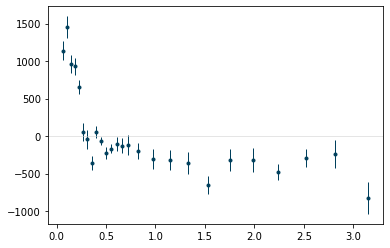

In [22]:
plt.errorbar(a_cl.z, a_cl.dNdz_b, a_cl.dNdz_b_err, c=c0, marker='.', ls='', lw=1)
plt.axhline(0, c='0.8', lw=0.5)

## Satellite candidates

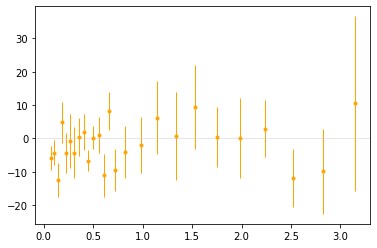

In [21]:
plt.errorbar(s_cl.z, s_cl.dNdz_b, s_cl.dNdz_b_err, c=c4, marker='.', ls='', lw=1)
plt.axhline(0, c='0.8', lw=0.5)

## Combined

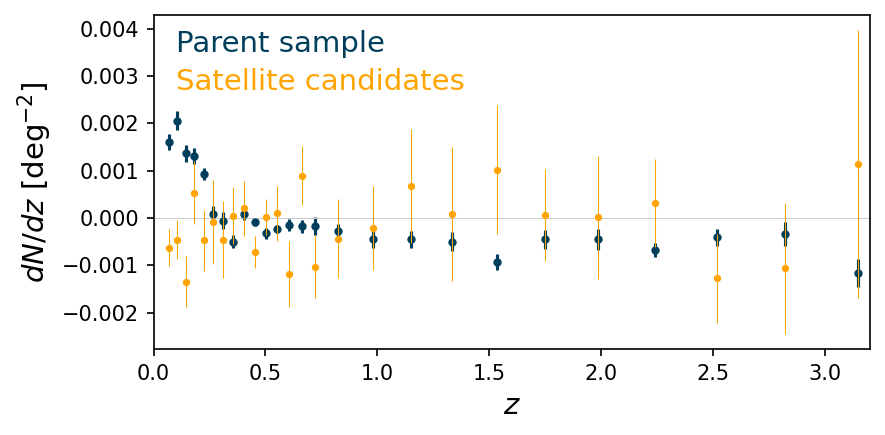

In [17]:
plt.figure(figsize=(6, 3), dpi=150)

plt.errorbar(s_cl.z, s_cl.dNdz_b/N_s, s_cl.dNdz_b_err/N_s, c=c4, marker='.', ls='', markersize=5, lw=0.5, alpha=1, zorder=6)
plt.errorbar(a_cl.z, a_cl.dNdz_b/N_a, a_cl.dNdz_b_err/N_a, c=c0, marker='.', ls='', lw=1.5, alpha=1)
plt.axhline(0, c='0.8', lw=0.5)

plt.xlim(0, 3.2)
plt.ylabel(r'$dN/dz$ [deg$^{-2}$]', fontsize=14)
plt.xlabel('$z$', fontsize=14)

plt.text(0.1, 0.0035, 'Parent sample', fontsize=14, color=c0)
plt.text(0.1, 0.0027, 'Satellite candidates', fontsize=14, color=c4)

plt.tight_layout()

# Dwarf galaxy structure

In [25]:
adf = pd.read_csv(ROOT/'results/predictions-initial.csv')
sdf = adf[adf.p_sat > 0.5]

N_a = len(adf)
N_s = len(sdf)

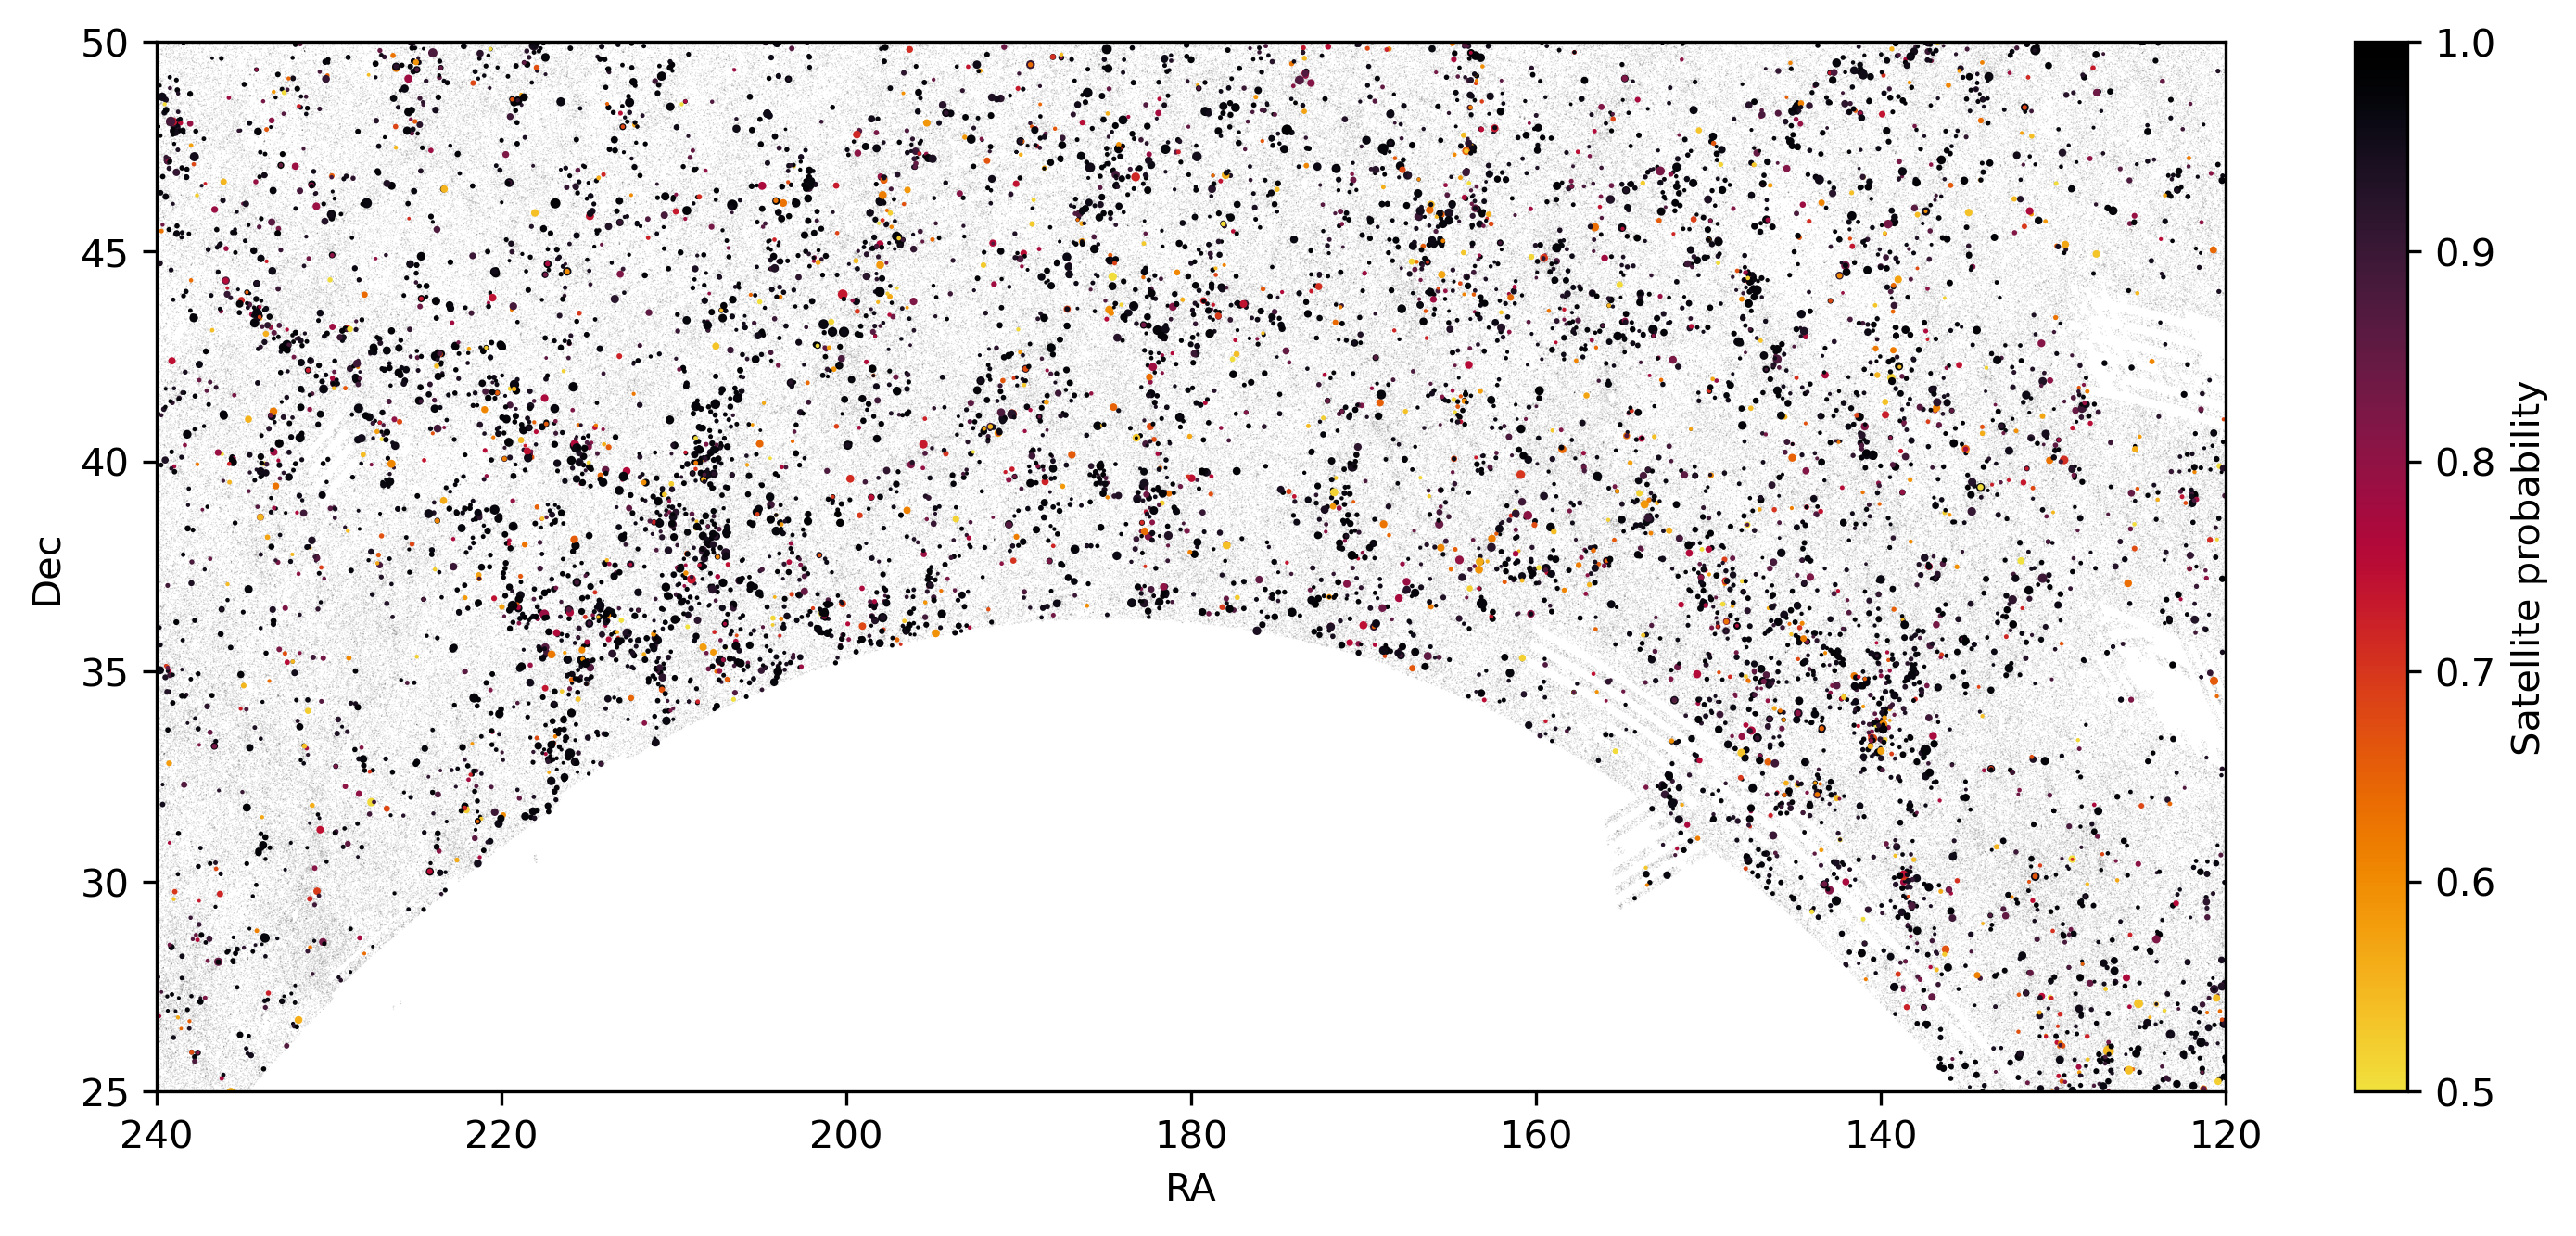

In [51]:
plt.figure(figsize=(12, 5), dpi=300)
plt.scatter(adf.ra, adf.dec, edgecolor='none', s=0.1, c='k', alpha=0.1)

sc = plt.scatter(sdf.ra, sdf.dec, c=sdf.p_sat, edgecolor='none', s=(sdf.r0/20)**-4, cmap='cmr.ember_r', vmin=0.5, vmax=1.)

plt.colorbar(sc, label='Satellite probability')

plt.xlim(240, 120)
plt.ylim(25, 50)

plt.xlabel('RA')
plt.ylabel('Dec');

# Compare with known NSA galaxies

## Low-redshift ($z < 0.03$)

In [30]:
nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')
len(nsa)

641409

In [32]:
nsa_z = nsa.Z
nsa_ra = nsa.RA
nsa_dec = nsa.DEC
nsa_mag = nsa.ELPETRO_ABSMAG[:, 4]

In [34]:
nsa_lowz = nsa_z < 0.03
sum(nsa_lowz)

50854

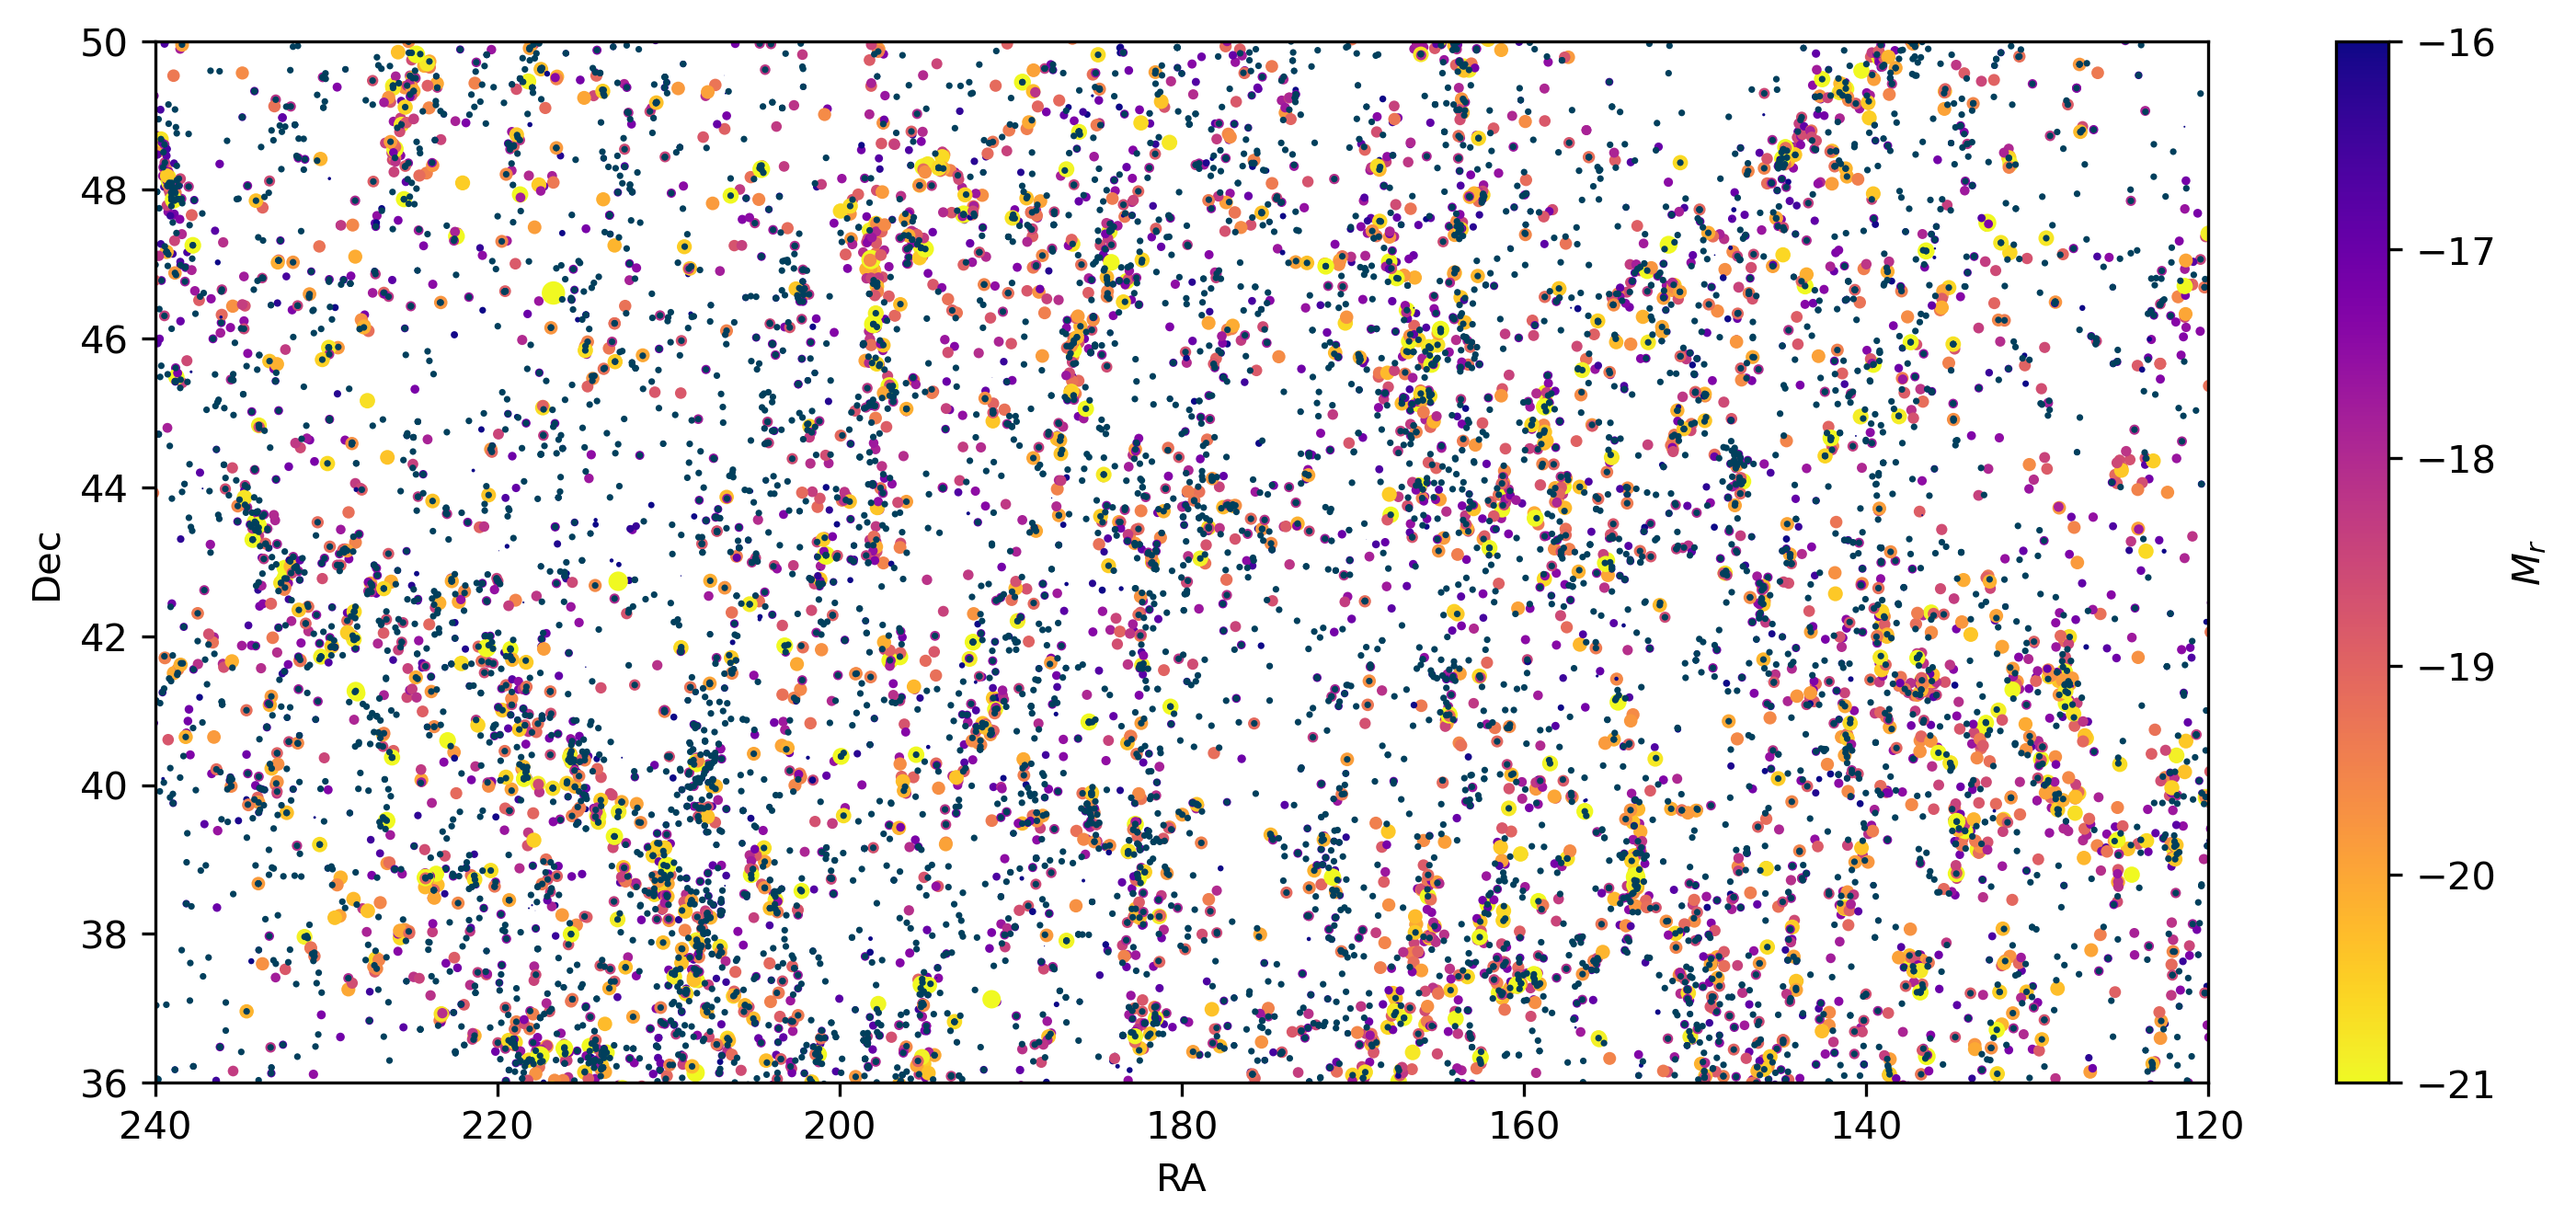

In [59]:
plt.figure(figsize=(12, 5), dpi=300)

sc = plt.scatter(nsa_ra[nsa_lowz], nsa_dec[nsa_lowz], c=nsa_mag[nsa_lowz], edgecolor='none', s=(nsa_mag[nsa_lowz]/13)**6, cmap='plasma_r', vmin=-21, vmax=-16)
plt.colorbar(sc, label='$M_{r}$')

plt.scatter(sdf.ra, sdf.dec, c=c0, edgecolor='none', s=3)

plt.xlim(240, 120)
plt.ylim(36, 50)       # only look at high lattitudes to remove the survey boundary

plt.xlabel('RA')
plt.ylabel('Dec');

## Crossmatch low-z candidates with confirmed catalogs

In [61]:
nsa_coords_lowz = SkyCoord(nsa_ra[nsa_lowz], nsa_dec[nsa_lowz], unit='deg')
sat_coords = SkyCoord(sdf.ra, sdf.dec, unit='deg')

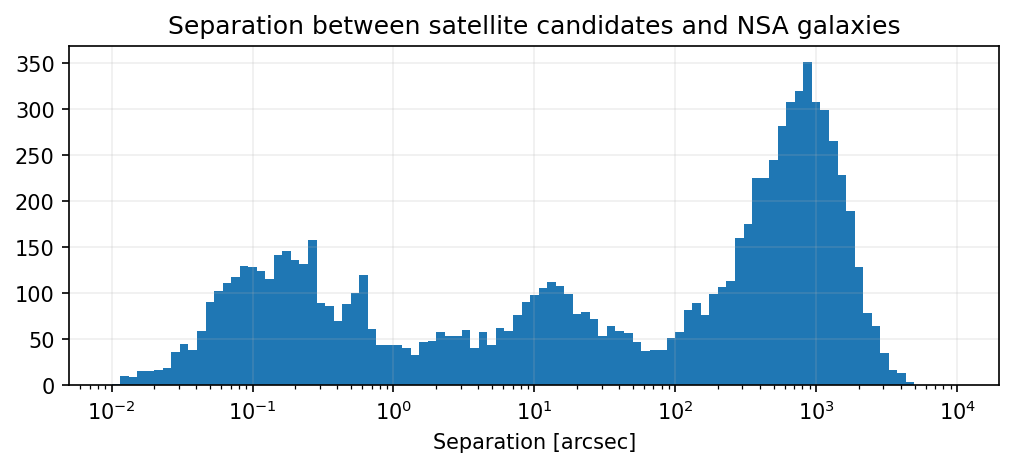

In [105]:
nsa_idx, sep, _ = sat_coords.match_to_catalog_sky(nsa_coords_lowz)
sep = sep.to('arcsec').value

plt.figure(figsize=(8,3), dpi=150)
plt.hist(sep, bins=np.logspace(-2, 4, num=100))
plt.xscale('log')
plt.xlabel('Separation [arcsec]')
plt.title('Separation between satellite candidates and NSA galaxies')
plt.grid(alpha=0.2);

Based on this, 1 arcsec seems like a good separation for matches. The peak is around 0.1 arcsec, which makes sense, but then around 10 arcsec we are likely matching with random $z \sim 0.2$ backgrounds, and then at 1000 arcsec we are probably matching with the nearest $L^*$ galaxy (host?). Or maybe the last bit is just a boundary effect.

In [73]:
len(nsa_idx), len(np.unique(nsa_idx))

(9231, 5149)

There are duplicate matches to NSA spec-$z$ confirmed gaalxies, i.e., we are definitely tracing multiple dwarfs around the same host. (And probably a small number of large nearby galaxies that were accidentally split into multiple images.)

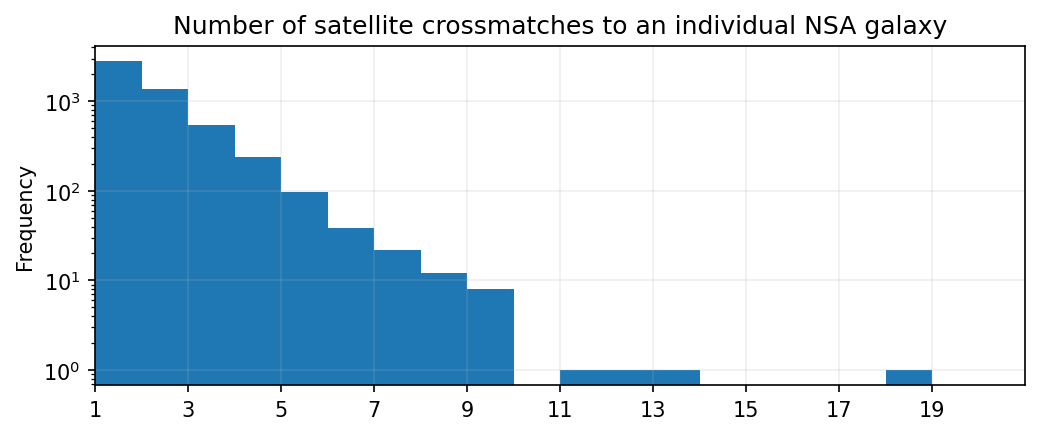

In [98]:
plt.figure(figsize=(8,3), dpi=150)
pd.Series(nsa_idx).value_counts().plot.hist(bins=20, range=(1,21), log=True)
plt.xlim(1, 21);
plt.xticks(np.arange(1, 21, 2))
plt.title('Number of satellite crossmatches to an individual NSA galaxy')
plt.grid(alpha=0.2)

Now add this to new dataframe and save results

In [160]:
sat_x_nsa = sdf.copy()

sat_x_nsa['z_NSA'] = nsa_z[nsa_lowz][nsa_idx]
sat_x_nsa['M_r_NSA'] = nsa_mag[nsa_lowz][nsa_idx]
sat_x_nsa['sep_NSA'] = sep
sat_x_nsa['ra_NSA'] = nsa_ra[nsa_lowz][nsa_idx]
sat_x_nsa['dec_NSA'] = nsa_dec[nsa_lowz][nsa_idx]

sat_x_nsa.sample(10, random_state=42)

objID          ra        dec        g0        r0  \
88801   1237661871873523796  206.144734  42.169513  15.97209  15.55049   
76094   1237664836467752982  137.020787  27.249905  14.97184  14.30392   
706796  1237657400272420901  140.762873  44.554925  14.14448  13.52396   
66148   1237662662670352906  216.320764  35.445465  20.16625  19.86662   
653032  1237664818211717387  177.310352  36.762467  17.56329  17.30067   
141071  1237664819828686982  195.494126  37.795033  16.09628  15.76636   
5635    1237664819823968342  181.820026  38.228409  20.38511  19.96255   
354869  1237662302971363676  213.994163  49.571121  17.93726  17.65908   
46482   1237661361296507105  197.388663  46.488094  18.56639  18.15312   
555630  1237662226224382000  212.508784  37.550969  14.86998  14.37513   

            R_eff     p_sat     z_NSA    M_r_NSA      sep_NSA      ra_NSA  \
88801    7.463689  0.979012  0.008980 -17.049103     0.195894  206.144801   
76094    9.088293  0.850783  0.021213 -19.879108     0.058900  137.020805   
706796  11.194550  0.977518  0.008867 -18.317438     0.389631  140.762738   
66148    2.789183  0.577062  0.028939 -18.040775   129.355783  216.288293   
653032   5.012787  0.525583  0.021963 -16.924253     0.406902  177.310426   
141071   3.922620  0.787859  0.027160 -17.405298  1156.676822  195.895135   
5635     2.363419  0.973367  0.023315 -18.049170  1210.385038  182.239825   
354869   5.765962  0.973230  0.026502 -19.071884   526.046360  214.212338   
46482    3.236506  0.894157  0.024556 -18.911005   739.759848  197.114483   
555630   6.858524  0.944627  0.026304 -20.311653     0.185679  212.508837   

          dec_NSA  
88801   42.169491  
76094   27.249903  
706796  44.554875  
66148   35.421152  
653032  36.762371  
141071  37.742602  
5635    38.294680  
354869  49.534807  
46482   46.569601  
555630  37.550940

In [161]:
# sat_x_nsa.to_csv(results_dir/'sat_x_NSA.csv', index=False)

## Sanity checks with outliers

For the matches, we would hope that the r magnitudes are similar to the ones derived in NSA? (Using the redshift)

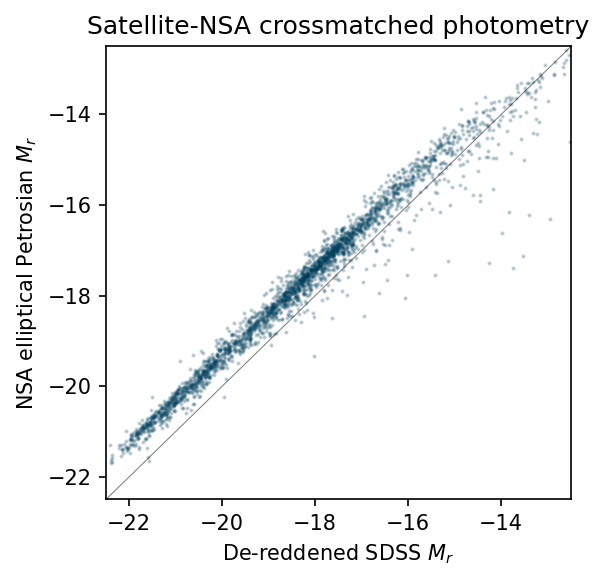

In [242]:
sat_matches = sat_x_nsa[(sat_x_nsa.sep_NSA < 1.) & (sat_x_nsa.z_NSA > 0)]

D_L = 3e5 / 70 * sat_matches.z_NSA # u.Mpc
M_r0 = sat_matches.r0 - 5*np.log10(D_L) - 25

plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(M_r0, sat_matches.M_r_NSA, s=1, alpha=0.2, c=c0)
plt.xlim(-22.5, -12.5)
plt.ylim(-22.5, -12.5)

plt.plot(plt.xlim(), plt.ylim(), c='k', alpha=0.5, lw=0.5)

plt.title('Satellite-NSA crossmatched photometry')
plt.xlabel('De-reddened SDSS $M_r$')
plt.ylabel('NSA elliptical Petrosian $M_r$');

That's basically fine, since obviously 3e5 is not exactly the speed of light and 70 is not $H_0$ in the appropriate units. However, there are a number of catastrophic outliers -- nearly all of which are below the 1-to-1 line. Let's see what's going on with them.

In [169]:
outlier_idx = (M_r0 > sat_matches.M_r_NSA).values

outliers = sat_matches.iloc[outlier_idx].copy()
outliers['M_r0'] = M_r0[outlier_idx]
outliers

objID          ra        dec        g0        r0  \
58      1237658611977683171  158.800296  46.236739  16.74269  16.63662   
593     1237664869748637938  138.301548  33.443336  18.00061  17.79888   
7235    1237657630592008449  146.763614  46.812000  17.38516  17.01059   
14203   1237662224605577257  188.469724  39.625920  16.16529  16.03928   
32762   1237661358620082187  191.597260  48.235201  15.43472  15.32081   
...                     ...         ...        ...       ...       ...   
697597  1237658205590650886  203.925059  49.176416  16.62436  16.47404   
700314  1237662224599547996  170.891824  38.726197  16.74217  16.09935   
701127  1237661435393999250  222.689923  41.628449  17.74219  17.35710   
701922  1237661358615035950  174.433763  47.893119  12.58321  12.01429   
706476  1237661381698519050  145.822540  34.064494  19.17438  18.76399   

            R_eff     p_sat     z_NSA    M_r_NSA   sep_NSA      ra_NSA  \
58       4.760215  0.973725  0.001683 -13.112530  0.156747  158.800279   
593      4.646336  0.970868  0.006076 -14.945798  0.149459  138.301557   
7235     8.528247  0.968619  0.015679 -17.165758  0.330489  146.763748   
14203    9.100364  0.979062  0.002162 -14.841435  0.291300  188.469823   
32762    6.551143  0.976830  0.003001 -15.429116  0.272905  191.597200   
...           ...       ...       ...        ...       ...         ...   
697597   9.062361  0.958352  0.002113 -14.406600  0.206881  203.924993   
700314   6.944490  0.976375  0.007183 -16.769279  0.246076  170.891768   
701127   7.431412  0.975996  0.008411 -15.720649  0.465236  222.689750   
701922  17.561010  0.979147  0.002392 -18.392923  0.232750  174.433689   
706476   1.877880  0.634209  0.028029 -17.944933  0.211145  145.822508   

          dec_NSA       M_r0  
58      46.236697 -12.653581  
593     33.443377 -14.279203  
7235    46.812001 -17.126138  
14203   39.625893 -13.794735  
32762   48.235266 -15.225443  
...           ...        ...  
697597  49.176454 -13.310446  
700314  38.726145 -16.342442  
701127  41.628462 -15.427258  
701922  47.893077 -18.039935  
706476  34.064442 -16.634156  

[174 rows x 13 columns]

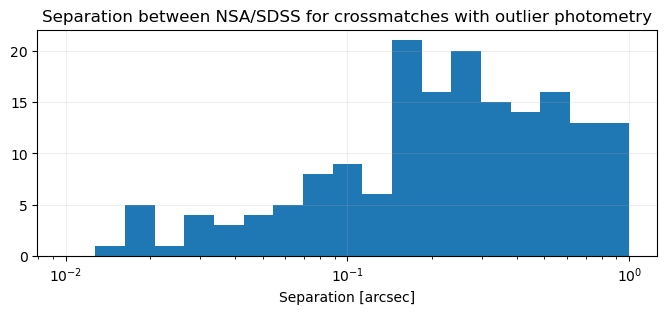

In [147]:
plt.figure(figsize=(8,3), dpi=100)
plt.hist(outliers.sep_NSA, bins=np.logspace(-2, 0, num=20))
plt.xscale('log')
plt.xlabel('Separation [arcsec]')
plt.title('Separation between NSA/SDSS for crossmatches with outlier photometry')
plt.grid(alpha=0.2);

Perhaps these have bright or weird background sources? Not super illuminating, so let's visualize a few. 

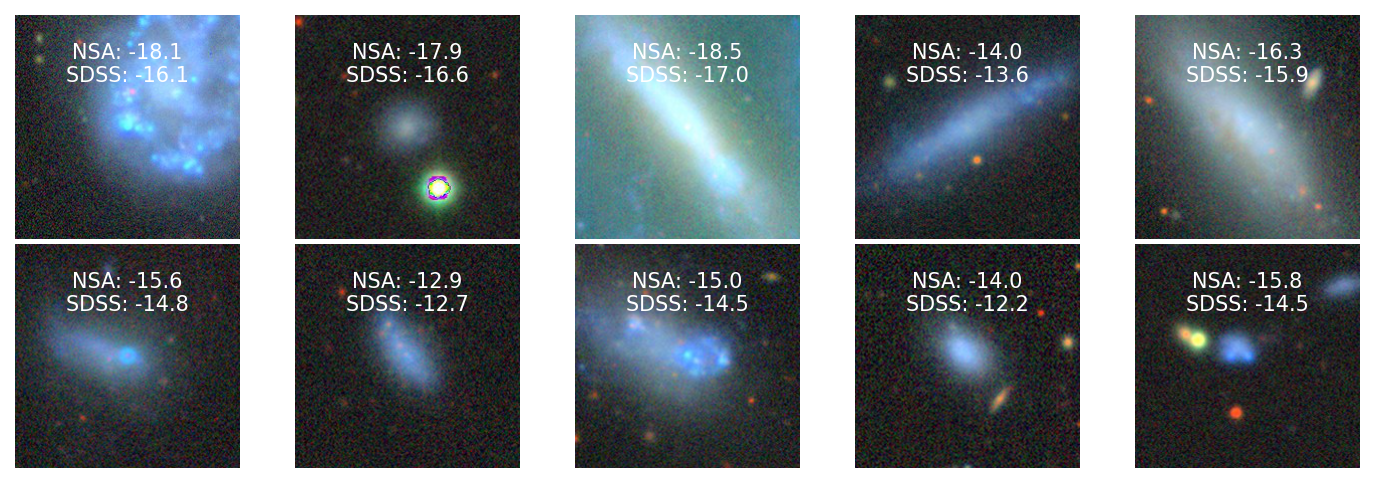

In [167]:
fig, axes = plt.subplots(2, 5, figsize=(12, 4), dpi=150)

for row, ax in zip(outliers.sample(10, random_state=12).itertuples(), axes.flat):
    url = (
        "http://legacysurvey.org/viewer/cutout.jpg"
        f"?ra={row.ra}"
        f"&dec={row.dec}"
        "&layer=dr8"
        "&size=224"
    )
    
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    
    ax.imshow(img)
    ax.text(0.5, 0.7, f'NSA: {row.M_r_NSA:.1f}\n' f'SDSS: {row.M_r0:.1f}', color='white', ha='center', transform=ax.transAxes)
    ax.axis('off')
    ax.set_aspect('equal')
    
fig.subplots_adjust(wspace=0.02, hspace=0.02)

Typical RA/Dec offsets for crossmatched *outliers*

In [171]:
outliers.ra - outliers.ra_NSA

58        0.000017
593      -0.000009
7235     -0.000134
14203    -0.000099
32762     0.000061
            ...   
697597    0.000066
700314    0.000056
701127    0.000172
701922    0.000074
706476    0.000032
Length: 174, dtype: float64

Text(0, 0.5, '$\\Delta$ Dec [arcsec]')

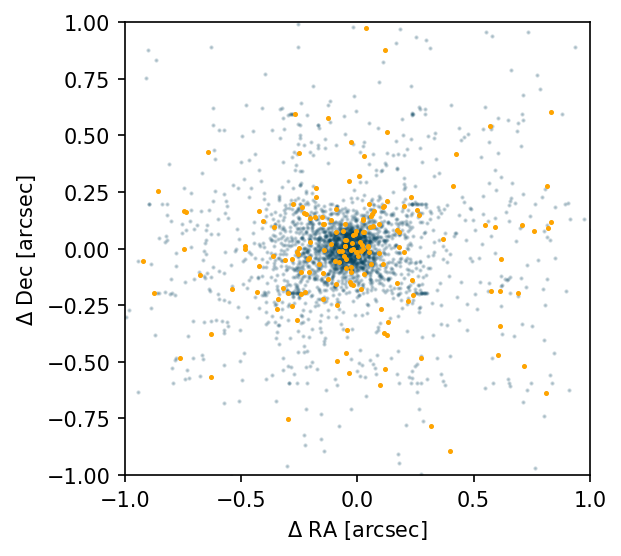

In [194]:
plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(3600*(sat_x_nsa.ra - sat_x_nsa.ra_NSA), 3600*(sat_x_nsa.dec - sat_x_nsa.dec_NSA), c=c0, alpha=0.2, s=1)

plt.scatter(3600*(outliers.ra - outliers.ra_NSA), 3600*(outliers.dec - outliers.dec_NSA), c=c4, s=2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel(r'$\Delta$ RA [arcsec]')
plt.ylabel(r'$\Delta$ Dec [arcsec]')

## LSS of crossmatches

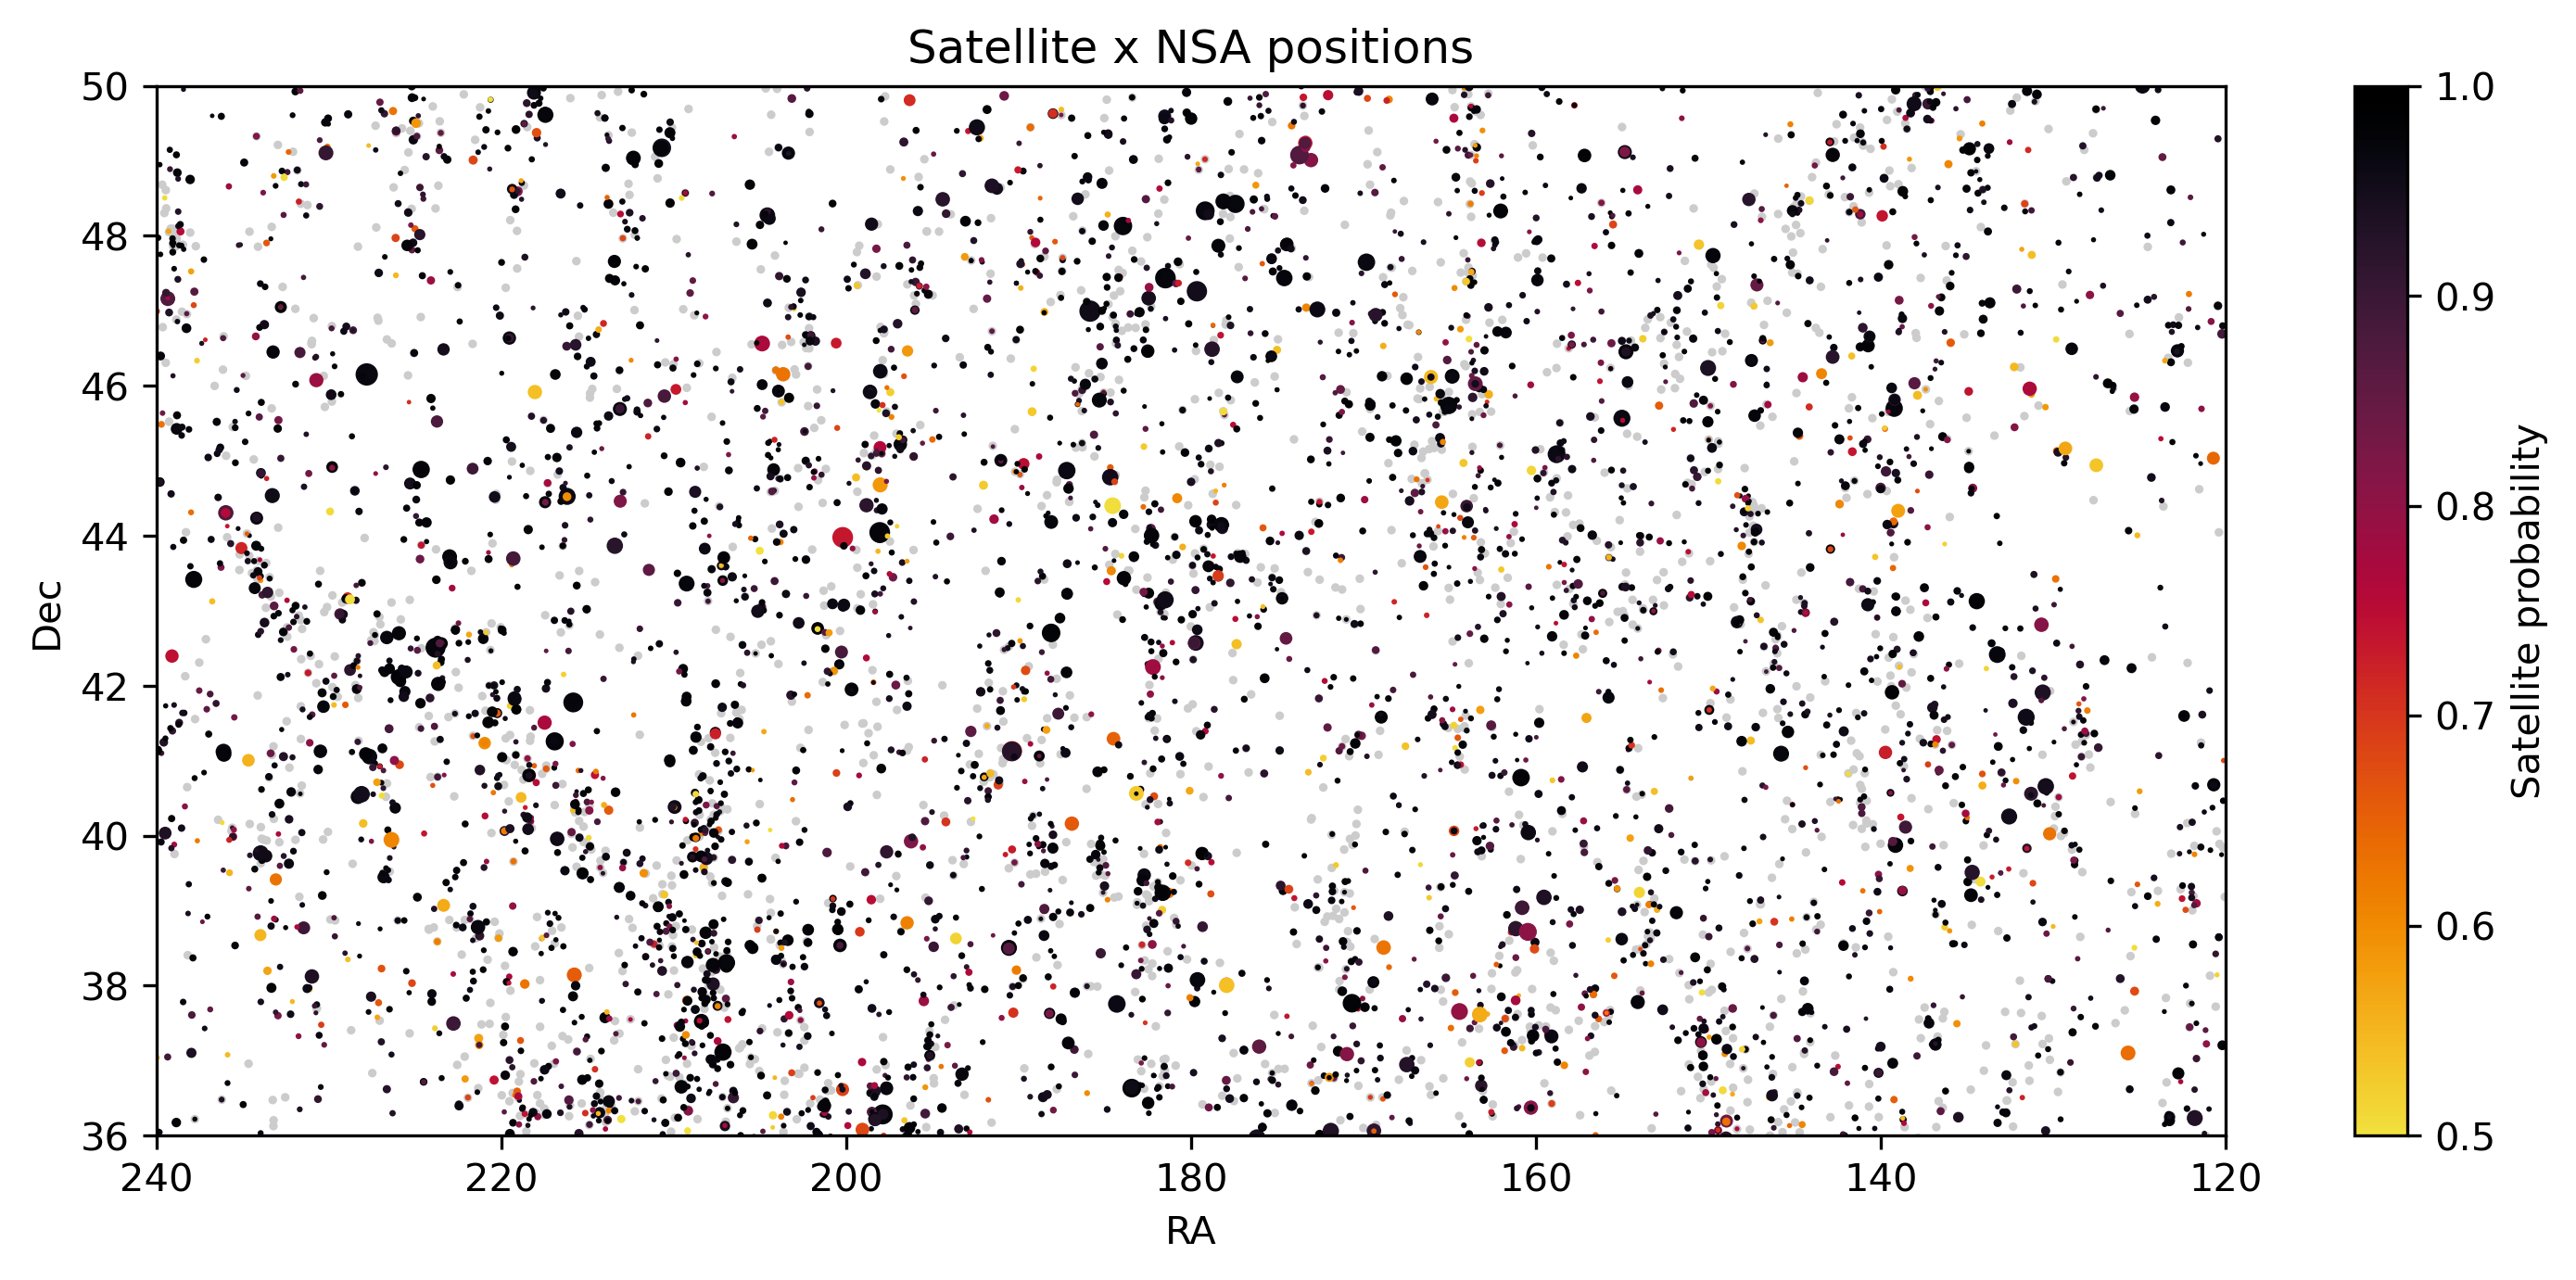

In [241]:
plt.figure(figsize=(12, 5), dpi=300)

xmatch = (sat_x_nsa.sep_NSA < 1.).values
plt.scatter(sat_x_nsa[xmatch].ra, sat_x_nsa[xmatch].dec, c='0.8', edgecolor='none', s=5)

sc = plt.scatter(sat_x_nsa[~xmatch].ra, sat_x_nsa[~xmatch].dec, c=sat_x_nsa[~xmatch].p_sat, edgecolor='none', s=(sat_x_nsa[~xmatch].r0/22)**-6, cmap='cmr.ember_r', vmin=0.5, vmax=1.)
plt.colorbar(sc, label='Satellite probability')

plt.xlim(240, 120)
plt.ylim(36, 50)       


plt.title('Satellite x NSA positions')
plt.xlabel('RA')
plt.ylabel('Dec');

# Configurations ofsatellites around an expanded sample of MW analogs: $-20 > M_r > -21$

In [245]:
# xmatch = (sat_x_nsa.sep_NSA < 1.)

# MW_like = (sat_x_nsa.M_r_NSA > -21) & (sat_x_nsa.M_r_NSA < -20) & xmatch
# sum(MW_like)

313

Note: I was using `sat_x_nsa` but I should just use `nsa` outright to identify hosts!!!

In [368]:
def load_NSA():
    """Returns dataframe with some NSA info.
    """
    nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

    # do this column by column, *not* on entire catalog
    byteorder = lambda x: x.byteswap().newbyteorder()

    # doesn't use .byteswap().newbyteorder() because that's super slow...
    return pd.DataFrame({
        'NSAID': byteorder(nsa.NSAID),
        'z_NSA': byteorder(nsa.Z),
        'ra_NSA': byteorder(nsa.RA),
        'dec_NSA': byteorder(nsa.DEC),
        'M_r_NSA': byteorder(nsa.ELPETRO_ABSMAG[:, 4])
    })

nsa = load_NSA()

In [362]:
MW_like = (nsa.M_r_NSA > -21) & (nsa.M_r_NSA < -20) & (nsa.z_NSA < 0.03)
sum(MW_like)

6124

If they're not within 1deg of a satellite then forget it

In [369]:
nsa = nsa[MW_like].copy()

nsa_coords = SkyCoord(nsa.ra_NSA, nsa.dec_NSA, unit='deg')

sat_idx, sep, _ = nsa_coords.match_to_catalog_sky(sat_coords)

# at least within 1 deg of a sat
nsa = nsa[sep < 1*u.deg].copy()
len(nsa)

842

## New satellites

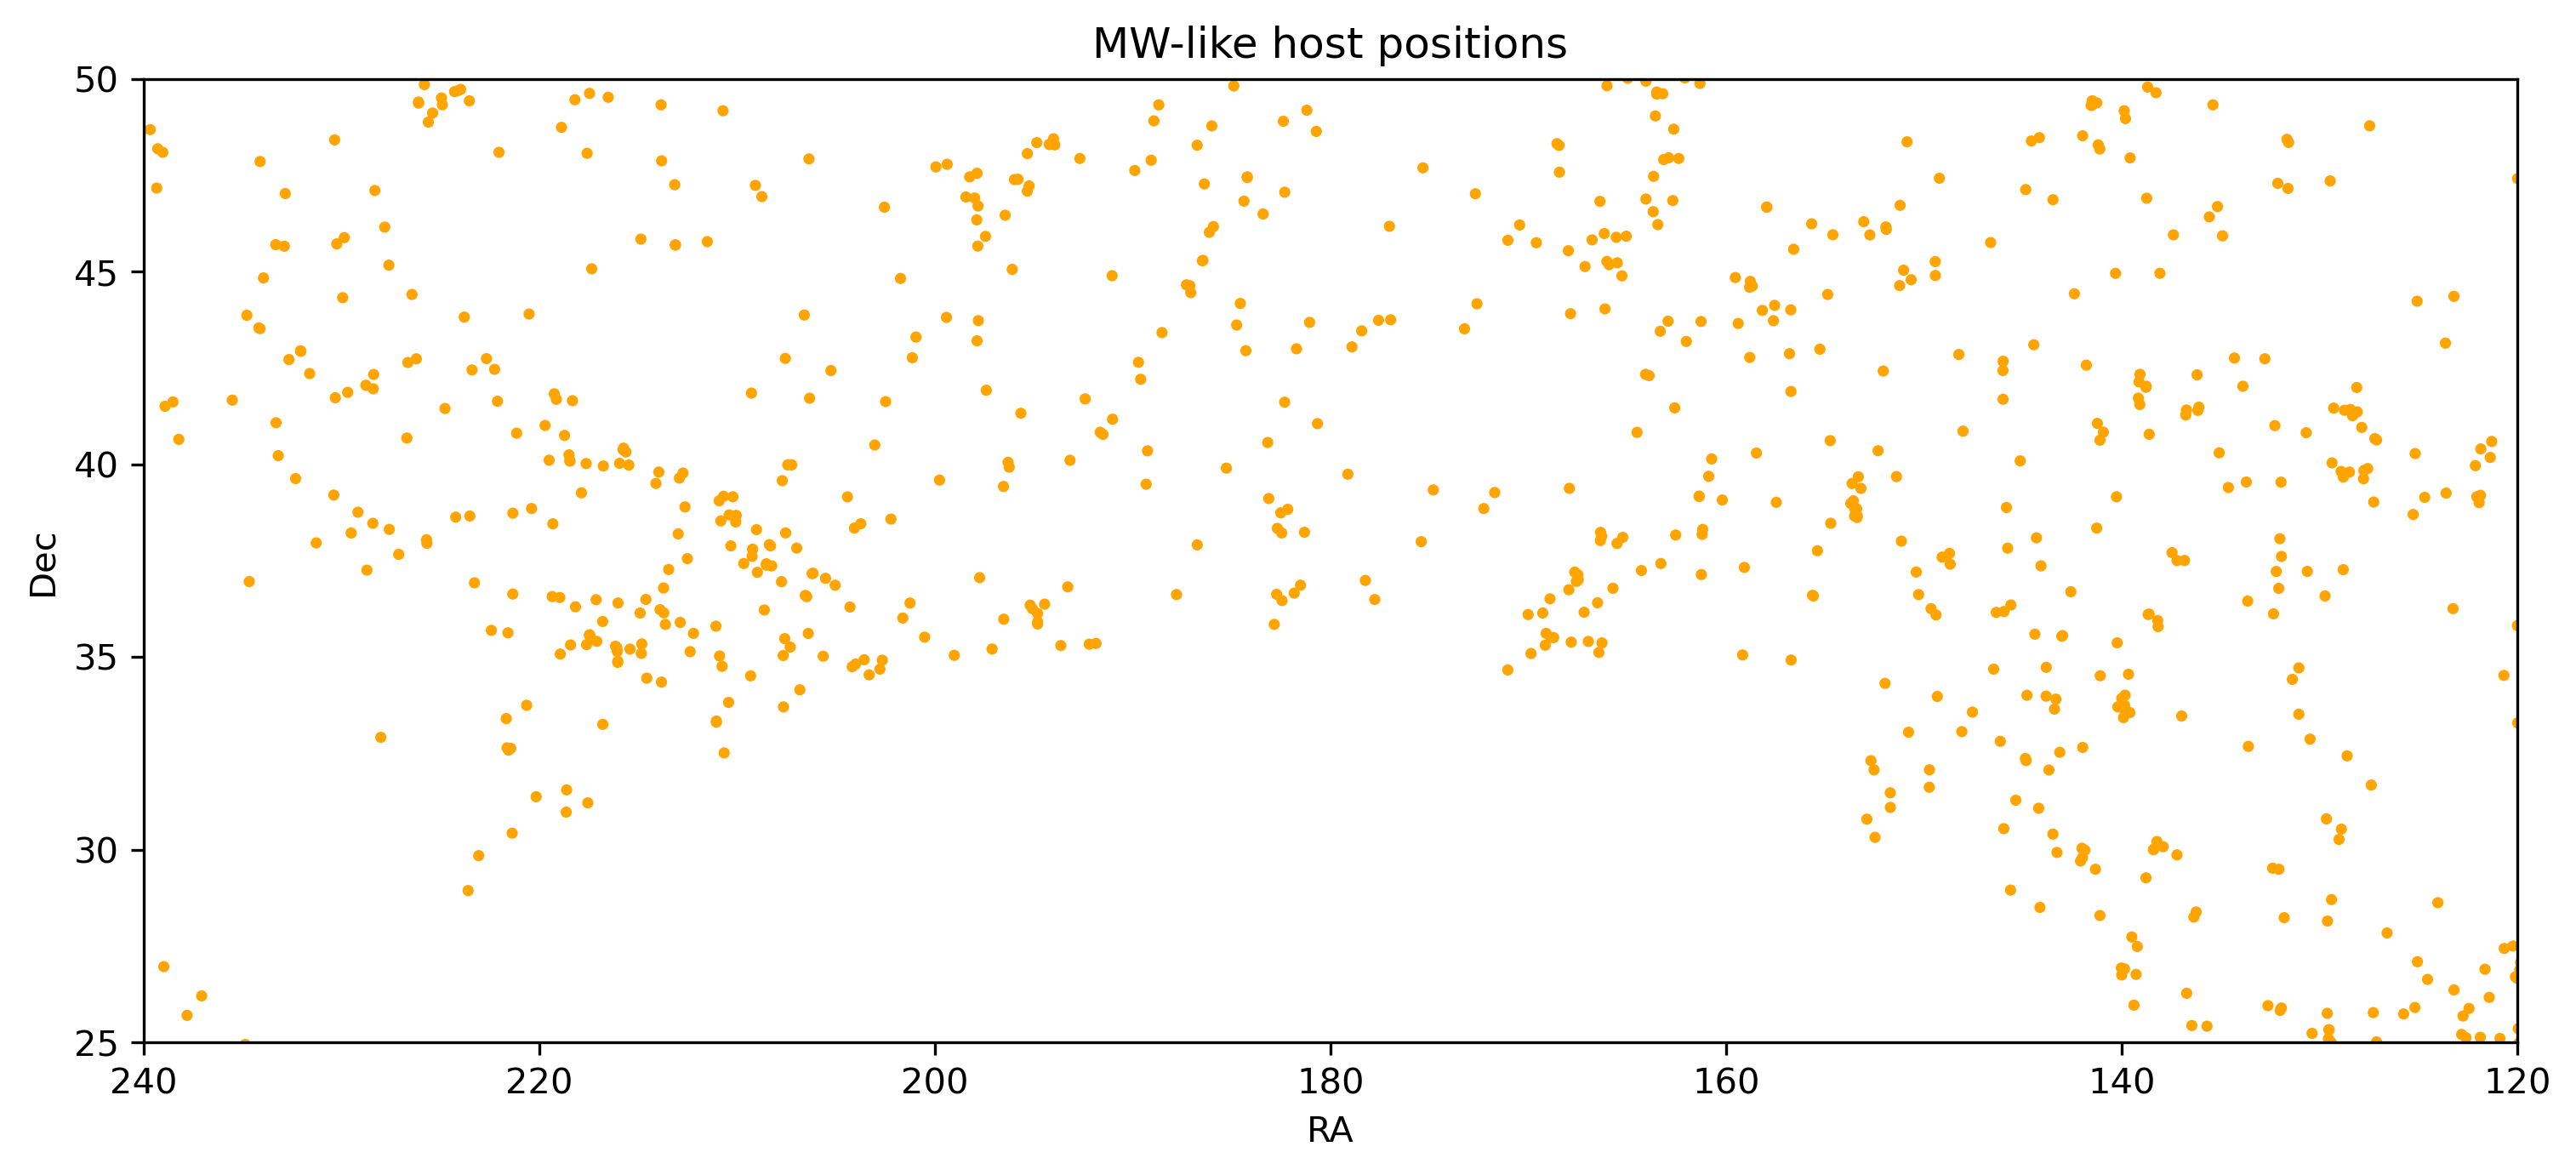

In [364]:
plt.figure(figsize=(12, 5), dpi=300)

plt.scatter(nsa.ra_NSA, nsa.dec_NSA, c=c4, edgecolor='none', s=10)

plt.xlim(240, 120)
plt.ylim(25, 50)       

plt.title('MW-like host positions')
plt.xlabel('RA')
plt.ylabel('Dec');

New satellites that *don't* have NSA redshifts

In [374]:
hosts = nsa.set_index('NSAID').copy()
host_coords = SkyCoord(hosts.ra_NSA, hosts.dec_NSA, unit='deg')

xmatch = (sat_x_nsa.sep_NSA < 1.)

new_sats = sat_x_nsa[~xmatch].copy()
new_sat_coords = SkyCoord(new_sats.ra, new_sats.dec, unit='deg')

host_idx, host_sep, _ = new_sat_coords.match_to_catalog_sky(host_coords)
host_sep = host_sep.to('arcsec').value

len(new_sats), len(hosts)

(6615, 842)

In [375]:
new_sats['host_nsaid'] = hosts.iloc[host_idx].index.values
new_sats['host_sep'] = host_sep

# only keep those with hosts that are < 1 degree
new_sats = new_sats[new_sats.host_sep < 3600].copy()
len(new_sats)

4871

In [379]:
grouped = new_sats.groupby('host_nsaid')

# iterate through the groups, one host at a time
host_nsaID, group = next(iter(grouped))

# disregard all columns ending with `_NSA` because the separations are at least 1 arcsec
print(f'Host ID = {host_nsaID} located at RA Dec = {hosts.loc[host_nsaID].ra_NSA:.6f} {hosts.loc[host_nsaID].dec_NSA:.6f}')
display(group)

Host ID = 47898 located at RA Dec = 123.197921 44.357359


objID          ra        dec        g0        r0  \
332471  1237651250945327463  123.077517  45.249703  19.19997  18.79228   
455176  1237654392179327488  123.700284  44.470086  19.85411  19.38105   

           R_eff     p_sat     z_NSA    M_r_NSA      sep_NSA      ra_NSA  \
332471  2.789752  0.974629  0.023345 -17.334787  1052.253320  122.784214   
455176  1.912438  0.933046  0.023599 -18.763628   288.834483  123.662048   

          dec_NSA  host_nsaid     host_sep  
332471  45.456953       47898  3227.127769  
455176  44.394643       47898  1354.065837

By using Yao's image list tool and copy+pasting the host and satellite RA/Dec, we can look at these... many do look like satellites (aside from the super nearby diffuse spiral galaxy, which is probably truly in the foreground, and the bright galaxy + host which were clipped into multiple sources)

## Old satellites (known sats, with NSA redshifts and small separations)

In [380]:
old_sats = sat_x_nsa[xmatch].copy()
old_sat_coords = SkyCoord(old_sats.ra, old_sats.dec, unit='deg')

host_idx, host_sep, _ = old_sat_coords.match_to_catalog_sky(host_coords)
host_sep = host_sep.to('arcsec').value

len(old_sats), len(hosts)

(2616, 842)

In [381]:
old_sats['host_nsaid'] = hosts.iloc[host_idx].index.values
old_sats['host_sep'] = host_sep

# only keep those with hosts that are < 1 degree
old_sats = old_sats[old_sats.host_sep < 3600].copy()
len(old_sats)

2058

In [382]:
grouped = old_sats.groupby('host_nsaid')
host_nsaID, group = next(iter(grouped))
print(f'Host ID = {host_nsaID} located at RA Dec = {hosts.loc[host_nsaID].ra_NSA:.6f} {hosts.loc[host_nsaID].dec_NSA:.6f}')
display(group)

Host ID = 47898 located at RA Dec = 123.197921 44.357359


objID          ra        dec        g0        r0  \
99359  1237654392179261669  123.601084  44.390974  18.08631  17.68751   

          R_eff     p_sat     z_NSA    M_r_NSA   sep_NSA      ra_NSA  \
99359  2.812383  0.961376  0.024009 -16.764641  0.280009  123.601161   

         dec_NSA  host_nsaid     host_sep  
99359  44.391029       47898  1044.466721

## Summary

An examination of [UGC 4436](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%40492961&Name=UGC%20%204436&submit=submit) (objID 1237651250947293406) as a host gave some nice insights. See in [Legacy viewer](https://www.legacysurvey.org/viewer?ra=127.459652&dec=48.781015&zoom=14&layer=ls-dr9). Out of 15 total satellites classified by the CNN, we find **4 known satellites**, **4 duplicate bright galaxies**, and perhaps **5(?) nice-looking candidates**.

For the current NSAID = 47898, we find 3 satellites (1 old, 2 new), all of which look quite plausible.

It probably makes sense to simply combine all satellites into the same catalog, since we can later distinguish which ones have NSA crossmatches (using the `sep_NSA` column). Let's do this now

## All satellite candidates grouped by host - save in `results/xSAGA-init/groupby-host/`

In [385]:
host_idx, host_sep, _ = sat_coords.match_to_catalog_sky(host_coords)
host_sep = host_sep.to('arcsec').value

all_sats = sat_x_nsa.copy() # all satellites including non-matches

all_sats['host_nsaid'] = hosts.iloc[host_idx].index.values
all_sats['host_sep'] = host_sep

all_sats = all_sats[all_sats.host_sep < 3600].copy()
len(all_sats)

6929

In [386]:
# verify that we get all 15 satellite candidates
grouped = all_sats.groupby('host_nsaid')

host_objID, group = next(iter(grouped))

print(f'Host ID = {host_nsaID} located at RA Dec = {hosts.loc[host_nsaID].ra_NSA:.6f} {hosts.loc[host_nsaID].dec_NSA:.6f}')
display(group)

Host ID = 47898 located at RA Dec = 123.197921 44.357359


objID          ra        dec        g0        r0  \
99359   1237654392179261669  123.601084  44.390974  18.08631  17.68751   
332471  1237651250945327463  123.077517  45.249703  19.19997  18.79228   
455176  1237654392179327488  123.700284  44.470086  19.85411  19.38105   

           R_eff     p_sat     z_NSA    M_r_NSA      sep_NSA      ra_NSA  \
99359   2.812383  0.961376  0.024009 -16.764641     0.280009  123.601161   
332471  2.789752  0.974629  0.023345 -17.334787  1052.253320  122.784214   
455176  1.912438  0.933046  0.023599 -18.763628   288.834483  123.662048   

          dec_NSA  host_nsaid     host_sep  
99359   44.391029       47898  1044.466721  
332471  45.456953       47898  3227.127769  
455176  44.394643       47898  1354.065837

In [387]:
for host_objID, group in tqdm(grouped):
    group.to_csv(results_dir/f'groupby-NSA-host_-21_-20/{host_nsaID}.csv', index=False)

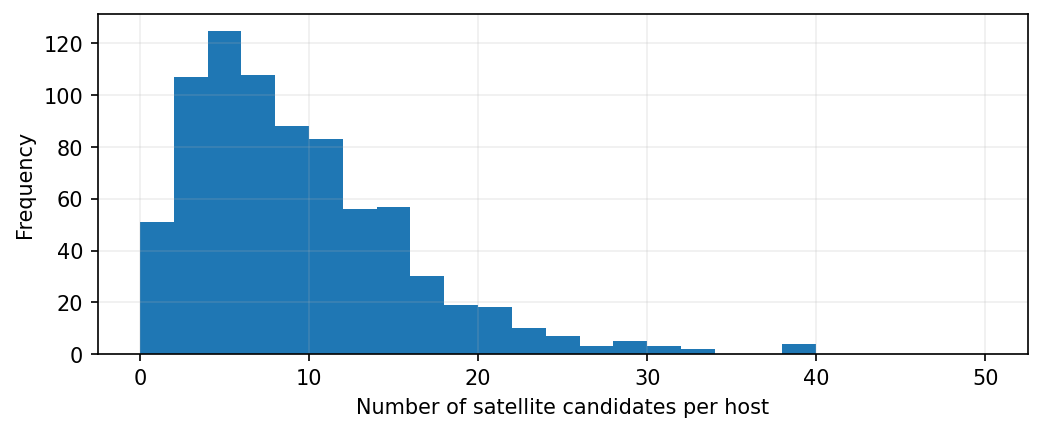

In [388]:
plt.figure(figsize=(8, 3), dpi=150)
grouped.size().plot.hist(bins=25, range=[0, 50])
plt.xlabel('Number of satellite candidates per host')
plt.grid(alpha=0.2)